# Sensitivity Analysis of Wind Farm Performance


In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# Detect notebook working directory
notebook_cwd = os.getcwd()

# Project root = one level up from notebooks/
project_root = os.path.abspath(os.path.join(notebook_cwd, ".."))

# Add project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import modules
from src.turbine import Turbine
from src.wake_model import velocity_deficit, is_in_wake


In [2]:
# Load turbine specs
data_path = os.path.join(project_root, "data", "turbine_specs.json")
with open(data_path, "r") as f:
    specs = json.load(f)

D = specs["rotor_diameter"]
C_T = specs["thrust_coefficient"]
P_rated = specs["rated_power_kw"]


In [3]:
def effective_speed(t, turbines, U_inf, k):
    """
    Compute effective wind speed at turbine t due to wakes.
    """
    deficits = []

    for u in turbines:
        if u.x >= t.x:
            continue

        if is_in_wake(t.x, t.y, u.x, u.y, u.R, k):
            dx = t.x - u.x
            dU = velocity_deficit(dx, U_inf, u.C_T, u.R, k) * U_inf
            deficits.append(dU)

    if not deficits:
        return U_inf

    total_deficit = np.sqrt(np.sum(np.array(deficits)**2))
    return max(U_inf - total_deficit, 0.0)


In [4]:
def compute_farm_power(spacing, U_inf, k):
    """
    Build a 3x3 farm with given spacing and compute total power.
    """
    turbines = []
    for i in range(3):
        for j in range(3):
            x = i * spacing
            y = j * spacing
            turbines.append(Turbine(x, y, D, C_T, P_rated))

    total_power = 0.0

    for t in turbines:
        U_eff = effective_speed(t, turbines, U_inf, k)
        P = P_rated * (U_eff / U_inf)**3
        P = min(P, P_rated)
        total_power += P

    return total_power


In [5]:
spacings = np.array([4*D, 5*D, 6*D, 7*D])
U_inf = 8.0
k = 0.04

powers_spacing = [compute_farm_power(s, U_inf, k) for s in spacings]
powers_spacing


[np.float64(14029.94433937315),
 np.float64(15042.272173917632),
 np.float64(15975.309685595088),
 np.float64(16826.699425253366)]

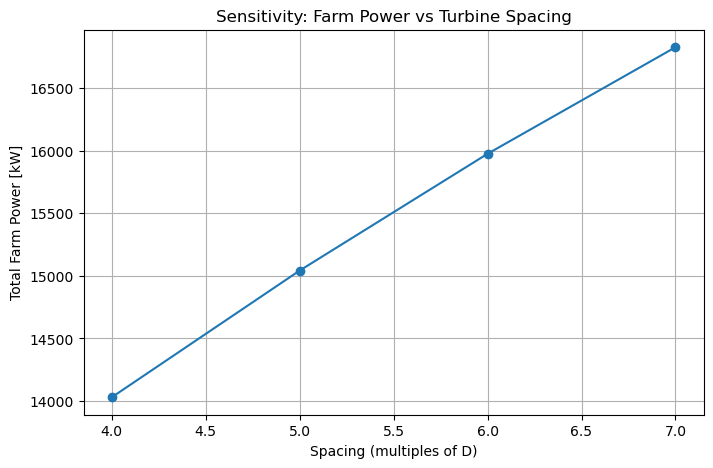

In [6]:
plt.figure(figsize=(8,5))
plt.plot(spacings/D, powers_spacing, marker="o")

plt.xlabel("Spacing (multiples of D)")
plt.ylabel("Total Farm Power [kW]")
plt.title("Sensitivity: Farm Power vs Turbine Spacing")
plt.grid(True)

results_dir = os.path.join(project_root, "results")
os.makedirs(results_dir, exist_ok=True)

plt.savefig(os.path.join(results_dir, "power_vs_spacing.png"),
            dpi=300, bbox_inches="tight")
plt.show()


In [7]:
wind_speeds = np.array([6, 8, 10, 12])
spacing = 5 * D
k = 0.04

powers_wind = [compute_farm_power(spacing, U, k) for U in wind_speeds]
powers_wind


[np.float64(15042.272173917632),
 np.float64(15042.272173917632),
 np.float64(15042.272173917632),
 np.float64(15042.272173917632)]

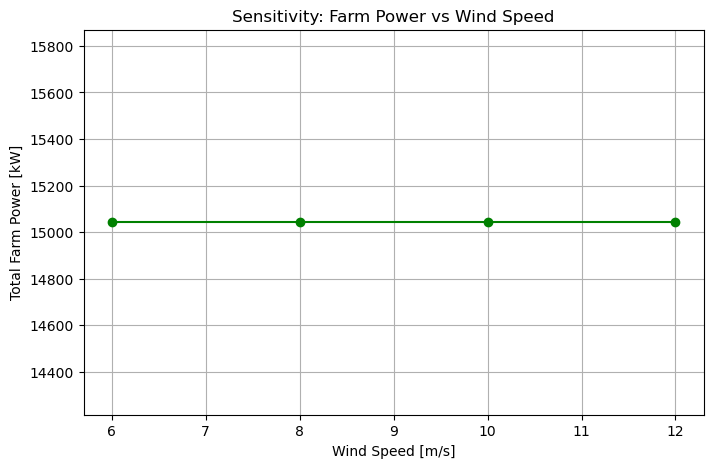

In [8]:
plt.figure(figsize=(8,5))
plt.plot(wind_speeds, powers_wind, marker="o", color="green")

plt.xlabel("Wind Speed [m/s]")
plt.ylabel("Total Farm Power [kW]")
plt.title("Sensitivity: Farm Power vs Wind Speed")
plt.grid(True)

plt.savefig(os.path.join(results_dir, "power_vs_windspeed.png"),
            dpi=300, bbox_inches="tight")
plt.show()


In [9]:
k_values = np.array([0.03, 0.04, 0.05])
spacing = 5 * D
U_inf = 8.0

powers_k = [compute_farm_power(spacing, U_inf, k) for k in k_values]
powers_k


[np.float64(13765.668821497922),
 np.float64(15042.272173917632),
 np.float64(16195.756507061596)]

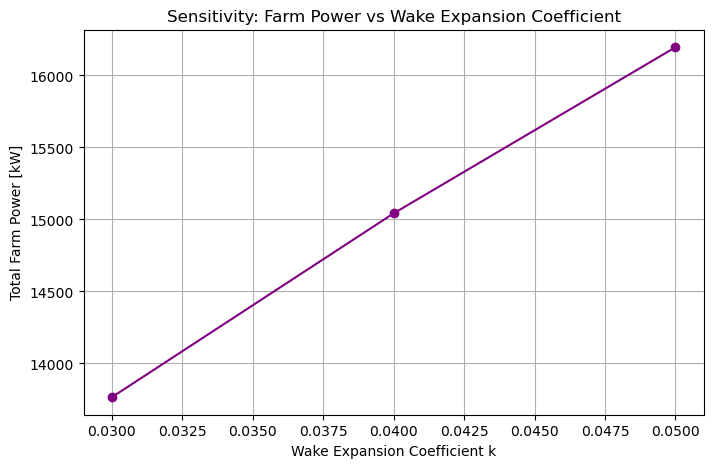

In [10]:
plt.figure(figsize=(8,5))
plt.plot(k_values, powers_k, marker="o", color="purple")

plt.xlabel("Wake Expansion Coefficient k")
plt.ylabel("Total Farm Power [kW]")
plt.title("Sensitivity: Farm Power vs Wake Expansion Coefficient")
plt.grid(True)

plt.savefig(os.path.join(results_dir, "power_vs_kfactor.png"),
            dpi=300, bbox_inches="tight")
plt.show()
